# Import the dependencies

In [31]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from matplotlib import pyplot as plt
from matplotlib import rcParams

import sys
import time

sys.path.append("../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

In [2]:
epochs = 25
num_neurons = 128
onehot_dims = 4

# Load & Prepare the data

In [3]:
enc_dict = {"(": [1.0, .0, .0, .0],
            ")": [.0, 1.0, .0, .0],
            "x": [.0, .0, 1.0, .0],
            "@x.": [.0, .0, .0, 1.0]}
tokens_pattern = r"(\(|\)|@x\.|x)"


def tokenize_data(simplified_term):
    return re.findall(tokens_pattern, simplified_term)


def tokenize_and_vectorize(x_data):
    vectorized_data_ = []
    for sample_ in x_data:
        tokens_ = tokenize_data(sample_)
        sample_vecs_ = []
        for token_ in tokens_:
            try:
                sample_vecs_.append(enc_dict[token_])
            except KeyError:
                pass
        vectorized_data_.append(sample_vecs_)
    return vectorized_data_

In [4]:
all_data = pd.read_csv("./data/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_lo that are more than 30
all_data = all_data[[steps_lo < 31 for steps_lo in all_data['steps_num_lo']]]

print(f"max steps count: {max(all_data['steps_num_lo'])}")
print(f"min steps count: {min(all_data['steps_num_lo'])}")

# make test/train split
x_train, x_test, y_train_, y_test_ = train_test_split(all_data["simple_terms"].tolist(),
                                                      all_data["steps_num_lo"].tolist(),
                                                      test_size=0.2, random_state=42)

print(f"Count training samples: {len(y_train_)}")
print(f"Count testing samples: {len(y_test_)}")

Count all terms: 4251

Count original terms: 4251

max steps count: 30
min steps count: 0
Count training samples: 2952
Count testing samples: 739


In [5]:
# one-hot encode y-data
encoder = LabelBinarizer()
encoder.fit(range(0, 31))
y_train = encoder.transform(y_train_)
y_test = encoder.transform(y_test_)

y_train_scaled = np.array(y_train_) / 30.0
y_test_scaled = np.array(y_test_) / 30.0

x_train = tokenize_and_vectorize(x_train)
x_test = tokenize_and_vectorize(x_test)

In [6]:
xy_train_data = list(zip(x_train, list(zip(y_train, y_train_scaled))))
xy_test_data = list(zip(x_test, list(zip(y_test, y_test_scaled))))

In [7]:
print(f"len(test_data) = {len(xy_test_data)}")
print(f"len(train_data) = {len(xy_train_data)}")

len(test_data) = 739
len(train_data) = 2952


In [8]:
def train_generator():
    while True:
        random.shuffle(xy_train_data)
        for xtd, ytd in xy_train_data:
            yield np.array([xtd]), (np.array([ytd[0]]), np.array([ytd[1]]))


def val_generator():
    while True:
        for xtd, ytd in xy_test_data:
            yield np.array([xtd]), (np.array([ytd[0]]), np.array([ytd[1]]))

# Define the model

In [41]:
# model = Sequential()
# model.add(LSTM(units=num_neurons,
#                input_shape=(None, onehot_dims)))
# model.add(Dense(units=31, activation='softmax'))

In [42]:
from keras.layers import Input
from keras.models import Model

input_layer = Input(shape=(None, onehot_dims))
lstm_layer = LSTM(units=num_neurons)(input_layer)

output_cl_layer = Dense(units=31, activation="softmax", name="cl_out")(lstm_layer)
output_reg_layer = Dense(units=1, name="reg_out")(lstm_layer)

model = Model(inputs=input_layer, outputs=[output_cl_layer, output_reg_layer])

In [43]:
model.compile(loss={'cl_out': 'categorical_crossentropy',
                    'reg_out': 'mean_squared_error'},
              loss_weights={'cl_out': 0.9,
                            'reg_out': 0.1},
              optimizer='adam',
              metrics={'cl_out': ['accuracy'], 'reg_out': ['mean_absolute_error']})
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None, 4)]            0         []                            
                                                                                                  
 lstm_4 (LSTM)               (None, 128)                  68096     ['input_5[0][0]']             
                                                                                                  
 cl_out (Dense)              (None, 31)                   3999      ['lstm_4[0][0]']              
                                                                                                  
 reg_out (Dense)             (None, 1)                    129       ['lstm_4[0][0]']              
                                                                                            

In [44]:
model_structure = model.to_json()
with open("./fine_models/v6_lstm_steps_pred_31_bins.json", 'w') as json_file:
    json_file.write(model_structure)

In [45]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='./fine_models/v6_lstm_steps_pred_31_bins.h5',  # Specify the path to save the best model
    monitor='cl_out_accuracy',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # 'min' or 'max' depending on the monitored metric
    verbose=0  # Print a message when saving the model
)

In [46]:
history = model.fit(train_generator(), steps_per_epoch=2952, validation_data=val_generator(), validation_steps=739, epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/25
2952/2952 [==============================] - 82s 27ms/step - loss: 2.7213 - cl_out_loss: 3.0180 - reg_out_loss: 0.0509 - cl_out_accuracy: 0.1108 - reg_out_mean_absolute_error: 0.1721 - val_loss: 2.6630 - val_cl_out_loss: 2.9525 - val_reg_out_loss: 0.0577 - val_cl_out_accuracy: 0.1096 - val_reg_out_mean_absolute_error: 0.1886
Epoch 2/25
   3/2952 [..............................] - ETA: 1:18 - loss: 2.0707 - cl_out_loss: 2.2968 - reg_out_loss: 0.0358 - cl_out_accuracy: 0.3333 - reg_out_mean_absolute_error: 0.1850    

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2952/2952 [==============================] - 82s 28ms/step - loss: 2.6175 - cl_out_loss: 2.9036 - reg_out_loss: 0.0427 - cl_out_accuracy: 0.1226 - reg_out_mean_absolute_error: 0.1581 - val_loss: 2.5333 - val_cl_out_loss: 2.8106 - val_reg_out_loss: 0.0371 - val_cl_out_accuracy: 0.1055 - val_reg_out_mean_absolute_error: 0.1496
Epoch 3/25
2952/2952 [==============================] - 80s 27ms/step - loss: 2.5369 - cl_out_loss: 2.8146 - reg_out_loss: 0.0380 - cl_out_accuracy: 0.1318 - reg_out_mean_absolute_error: 0.1439 - val_loss: 2.4857 - val_cl_out_loss: 2.7585 - val_reg_out_loss: 0.0306 - val_cl_out_accuracy: 0.1340 - val_reg_out_mean_absolute_error: 0.1288
Epoch 4/25
2952/2952 [==============================] - 77s 26ms/step - loss: 2.4307 - cl_out_loss: 2.6971 - reg_out_loss: 0.0326 - cl_out_accuracy: 0.1467 - reg_out_mean_absolute_error: 0.1309 - val_loss: 2.4105 - val_cl_out_loss: 2.6749 - val_reg_out_loss: 0.0313 - val_cl_out_accuracy: 0.1488 - val_reg_out_mean_absolute_error: 0.13

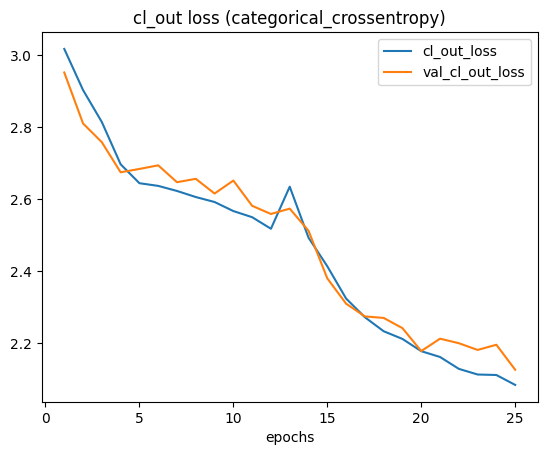

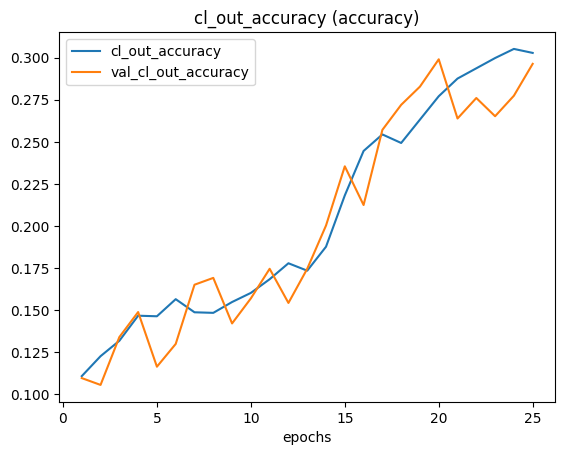

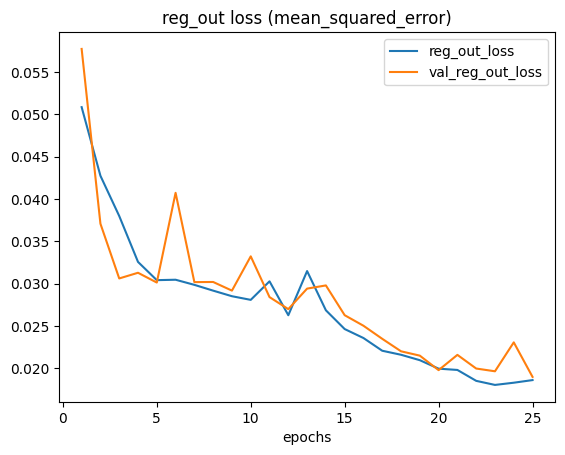

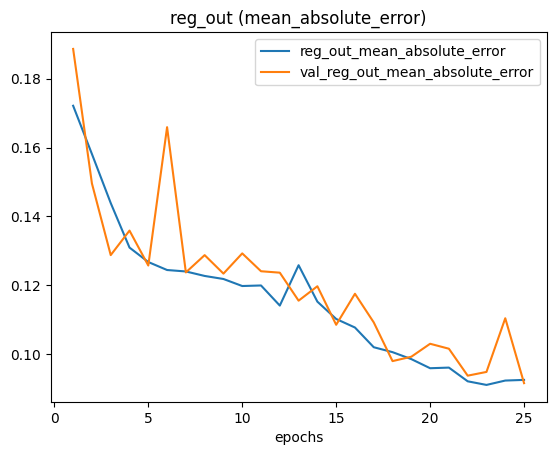

In [50]:
plt.plot(range(1, epochs + 1), history.history['cl_out_loss'], label="cl_out_loss")
plt.plot(range(1, epochs + 1), history.history['val_cl_out_loss'], label="val_cl_out_loss")
plt.xlabel("epochs")
plt.title("cl_out loss (categorical_crossentropy)")

plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), history.history['cl_out_accuracy'], label="cl_out_accuracy")
plt.plot(range(1, epochs + 1), history.history['val_cl_out_accuracy'], label="val_cl_out_accuracy")
plt.xlabel("epochs")
plt.title("cl_out_accuracy (accuracy)")

plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), history.history['reg_out_loss'], label="reg_out_loss")
plt.plot(range(1, epochs + 1), history.history['val_reg_out_loss'], label="val_reg_out_loss")
plt.xlabel("epochs")
plt.title("reg_out loss (mean_squared_error)")

plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), history.history['reg_out_mean_absolute_error'], label="reg_out_mean_absolute_error")
plt.plot(range(1, epochs + 1), history.history['val_reg_out_mean_absolute_error'], label="val_reg_out_mean_absolute_error")
plt.xlabel("epochs")
plt.title("reg_out (mean_absolute_error)")

plt.legend()
plt.show()

In [51]:
history = model.fit(train_generator(), steps_per_epoch=2952, validation_data=val_generator(), validation_steps=739, epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/25
2952/2952 [==============================] - 80s 27ms/step - loss: 1.8630 - cl_out_loss: 2.0680 - reg_out_loss: 0.0176 - cl_out_accuracy: 0.3096 - reg_out_mean_absolute_error: 0.0898 - val_loss: 1.9677 - val_cl_out_loss: 2.1838 - val_reg_out_loss: 0.0222 - val_cl_out_accuracy: 0.2869 - val_reg_out_mean_absolute_error: 0.1024
Epoch 2/25
   5/2952 [..............................] - ETA: 1:30 - loss: 1.7606 - cl_out_loss: 1.9548 - reg_out_loss: 0.0130 - cl_out_accuracy: 0.2000 - reg_out_mean_absolute_error: 0.0823    

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2952/2952 [==============================] - 80s 27ms/step - loss: 1.8275 - cl_out_loss: 2.0287 - reg_out_loss: 0.0169 - cl_out_accuracy: 0.3147 - reg_out_mean_absolute_error: 0.0889 - val_loss: 1.9180 - val_cl_out_loss: 2.1291 - val_reg_out_loss: 0.0183 - val_cl_out_accuracy: 0.2936 - val_reg_out_mean_absolute_error: 0.0901
Epoch 3/25
2952/2952 [==============================] - 84s 28ms/step - loss: 1.7958 - cl_out_loss: 1.9936 - reg_out_loss: 0.0154 - cl_out_accuracy: 0.3310 - reg_out_mean_absolute_error: 0.0839 - val_loss: 1.8809 - val_cl_out_loss: 2.0882 - val_reg_out_loss: 0.0150 - val_cl_out_accuracy: 0.3058 - val_reg_out_mean_absolute_error: 0.0841
Epoch 4/25
2952/2952 [==============================] - 82s 28ms/step - loss: 1.7649 - cl_out_loss: 1.9594 - reg_out_loss: 0.0146 - cl_out_accuracy: 0.3249 - reg_out_mean_absolute_error: 0.0806 - val_loss: 1.9402 - val_cl_out_loss: 2.1538 - val_reg_out_loss: 0.0173 - val_cl_out_accuracy: 0.2869 - val_reg_out_mean_absolute_error: 0.09

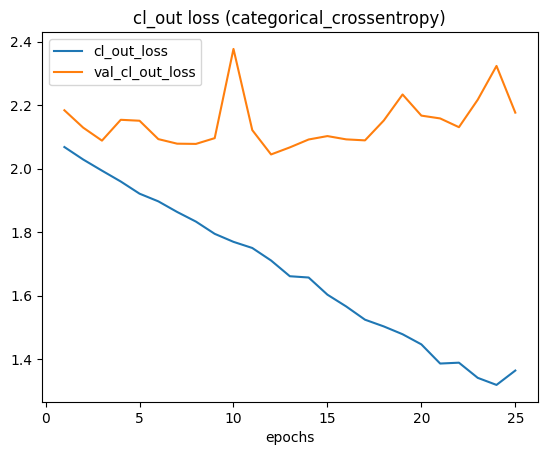

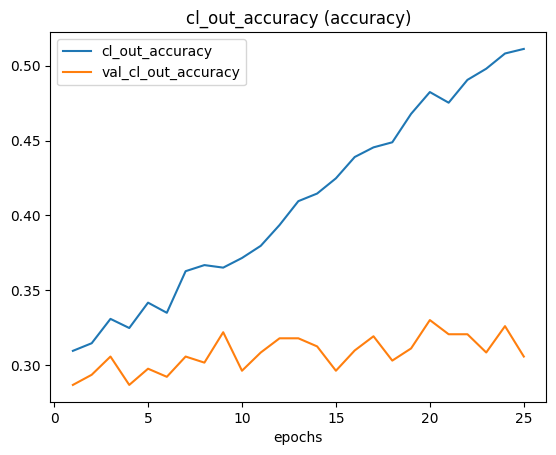

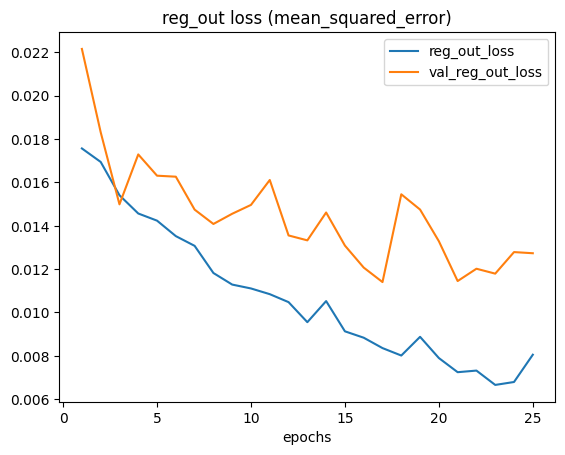

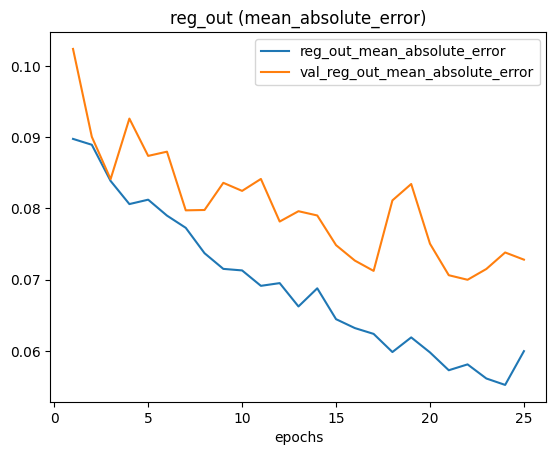

In [52]:
plt.plot(range(1, epochs + 1), history.history['cl_out_loss'], label="cl_out_loss")
plt.plot(range(1, epochs + 1), history.history['val_cl_out_loss'], label="val_cl_out_loss")
plt.xlabel("epochs")
plt.title("cl_out loss (categorical_crossentropy)")

plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), history.history['cl_out_accuracy'], label="cl_out_accuracy")
plt.plot(range(1, epochs + 1), history.history['val_cl_out_accuracy'], label="val_cl_out_accuracy")
plt.xlabel("epochs")
plt.title("cl_out_accuracy (accuracy)")

plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), history.history['reg_out_loss'], label="reg_out_loss")
plt.plot(range(1, epochs + 1), history.history['val_reg_out_loss'], label="val_reg_out_loss")
plt.xlabel("epochs")
plt.title("reg_out loss (mean_squared_error)")

plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), history.history['reg_out_mean_absolute_error'], label="reg_out_mean_absolute_error")
plt.plot(range(1, epochs + 1), history.history['val_reg_out_mean_absolute_error'], label="val_reg_out_mean_absolute_error")
plt.xlabel("epochs")
plt.title("reg_out (mean_absolute_error)")

plt.legend()
plt.show()

In [53]:
history = model.fit(train_generator(), steps_per_epoch=2952, validation_data=val_generator(), validation_steps=739, epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/25
2952/2952 [==============================] - 81s 28ms/step - loss: 1.1277 - cl_out_loss: 1.2522 - reg_out_loss: 0.0065 - cl_out_accuracy: 0.5342 - reg_out_mean_absolute_error: 0.0540 - val_loss: 2.0154 - val_cl_out_loss: 2.2381 - val_reg_out_loss: 0.0109 - val_cl_out_accuracy: 0.3261 - val_reg_out_mean_absolute_error: 0.0690
Epoch 2/25
   7/2952 [..............................] - ETA: 1:02 - loss: 0.7174 - cl_out_loss: 0.7971 - reg_out_loss: 5.4837e-04 - cl_out_accuracy: 0.8571 - reg_out_mean_absolute_error: 0.0181

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2952/2952 [==============================] - 81s 27ms/step - loss: 1.1082 - cl_out_loss: 1.2307 - reg_out_loss: 0.0061 - cl_out_accuracy: 0.5383 - reg_out_mean_absolute_error: 0.0536 - val_loss: 2.0740 - val_cl_out_loss: 2.3031 - val_reg_out_loss: 0.0123 - val_cl_out_accuracy: 0.3248 - val_reg_out_mean_absolute_error: 0.0710
Epoch 3/25
2952/2952 [==============================] - 79s 27ms/step - loss: 1.1095 - cl_out_loss: 1.2320 - reg_out_loss: 0.0068 - cl_out_accuracy: 0.5440 - reg_out_mean_absolute_error: 0.0556 - val_loss: 2.1285 - val_cl_out_loss: 2.3637 - val_reg_out_loss: 0.0111 - val_cl_out_accuracy: 0.3329 - val_reg_out_mean_absolute_error: 0.0724
Epoch 4/25
2952/2952 [==============================] - 79s 27ms/step - loss: 1.0959 - cl_out_loss: 1.2170 - reg_out_loss: 0.0063 - cl_out_accuracy: 0.5349 - reg_out_mean_absolute_error: 0.0546 - val_loss: 2.1314 - val_cl_out_loss: 2.3670 - val_reg_out_loss: 0.0109 - val_cl_out_accuracy: 0.3194 - val_reg_out_mean_absolute_error: 0.06

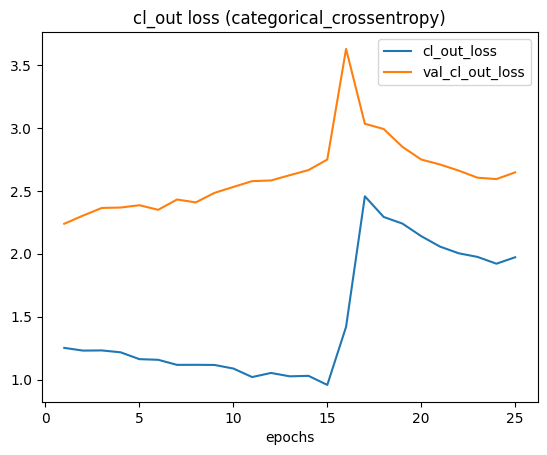

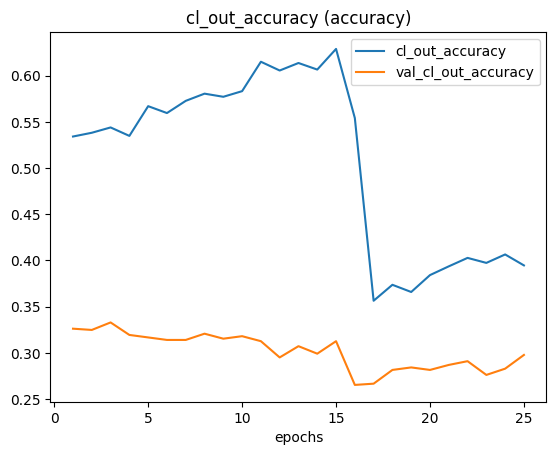

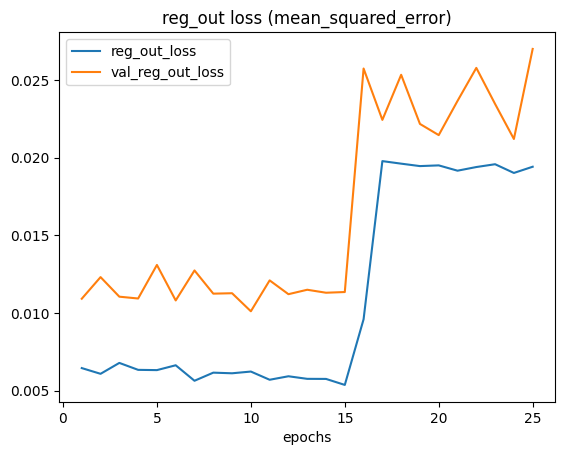

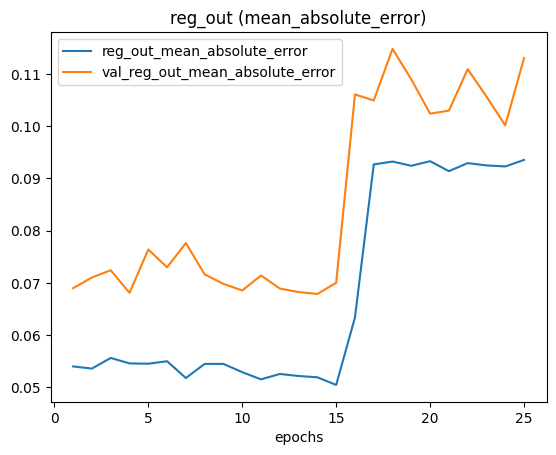

In [54]:
plt.plot(range(1, epochs + 1), history.history['cl_out_loss'], label="cl_out_loss")
plt.plot(range(1, epochs + 1), history.history['val_cl_out_loss'], label="val_cl_out_loss")
plt.xlabel("epochs")
plt.title("cl_out loss (categorical_crossentropy)")

plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), history.history['cl_out_accuracy'], label="cl_out_accuracy")
plt.plot(range(1, epochs + 1), history.history['val_cl_out_accuracy'], label="val_cl_out_accuracy")
plt.xlabel("epochs")
plt.title("cl_out_accuracy (accuracy)")

plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), history.history['reg_out_loss'], label="reg_out_loss")
plt.plot(range(1, epochs + 1), history.history['val_reg_out_loss'], label="val_reg_out_loss")
plt.xlabel("epochs")
plt.title("reg_out loss (mean_squared_error)")

plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), history.history['reg_out_mean_absolute_error'], label="reg_out_mean_absolute_error")
plt.plot(range(1, epochs + 1), history.history['val_reg_out_mean_absolute_error'], label="val_reg_out_mean_absolute_error")
plt.xlabel("epochs")
plt.title("reg_out (mean_absolute_error)")

plt.legend()
plt.show()

In [9]:
# load the model
with open("./fine_models/v6_lstm_steps_pred_31_bins.json", "r") as file:
    loaded_model_json = file.read()

model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights("./fine_models/v6_lstm_steps_pred_31_bins.h5")

In [16]:
y_train_pred = []
y_train_pred_reg = []
for x_ in tqdm(x_train):
    prediction = model.predict(np.array([x_]), verbose=0)
    y_train_pred.append(prediction[0])
    y_train_pred_reg.append(prediction[1])

100%|██████████| 2952/2952 [02:53<00:00, 17.04it/s]


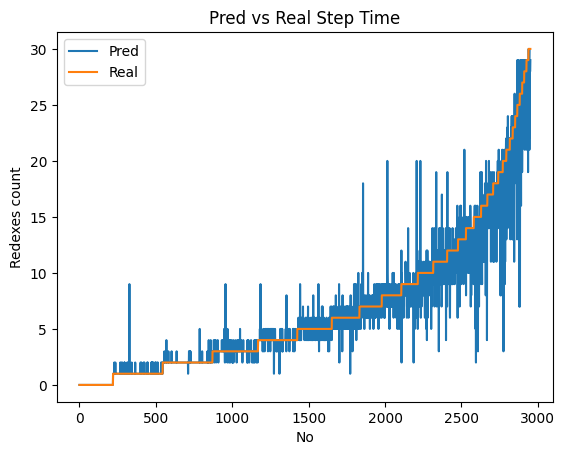

In [17]:
y_train_pred_nums = [np.argmax(y_) for y_ in y_train_pred]
y_train_nums = encoder.inverse_transform(y_train)

draw_pred_lines(y_train_pred_nums, y_train_nums)

In [18]:
print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))

Train accuracy: 0.6548102981029811


In [10]:
y_test_pred = []
y_test_pred_reg = []
for x_ in tqdm(x_test):
    prediction = model.predict(np.array([x_]), verbose=0)
    y_test_pred.append(prediction[0])
    y_test_pred_reg.append(prediction[1])

100%|██████████| 739/739 [00:44<00:00, 16.64it/s]


In [11]:
def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Redexes count")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

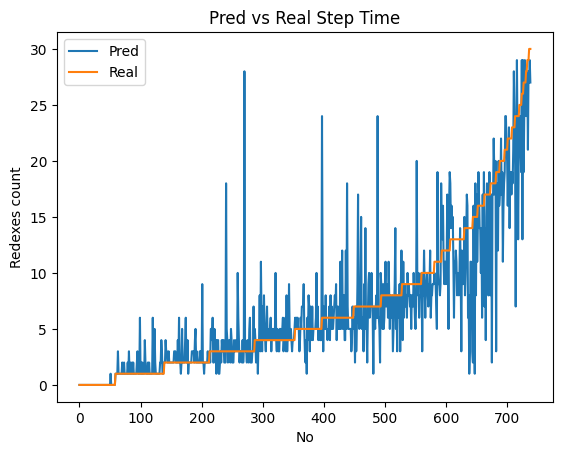

In [12]:
y_test_pred_nums = [np.argmax(y_) for y_ in y_test_pred]
y_test_nums = encoder.inverse_transform(y_test)

draw_pred_lines(y_test_pred_nums, y_test_nums)

In [13]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))

Test accuracy: 0.3125845737483085


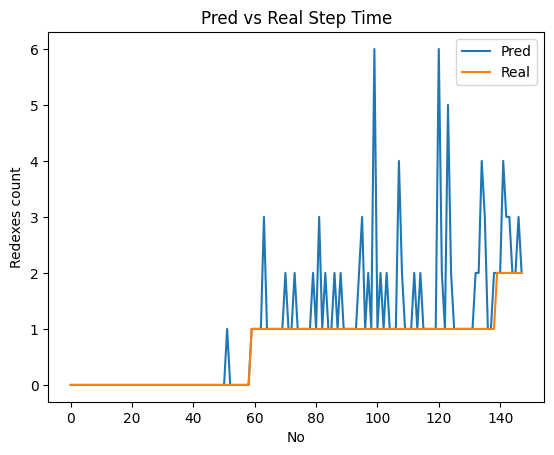

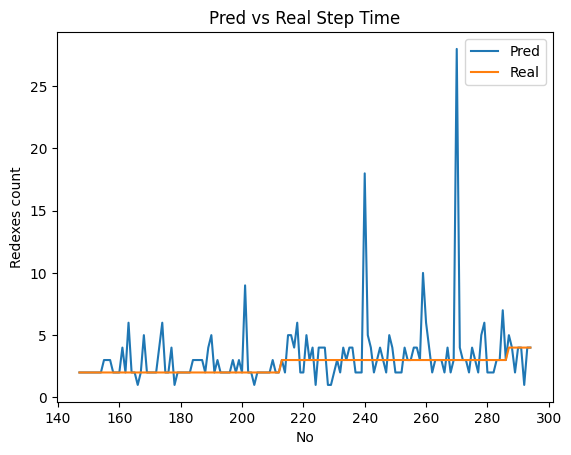

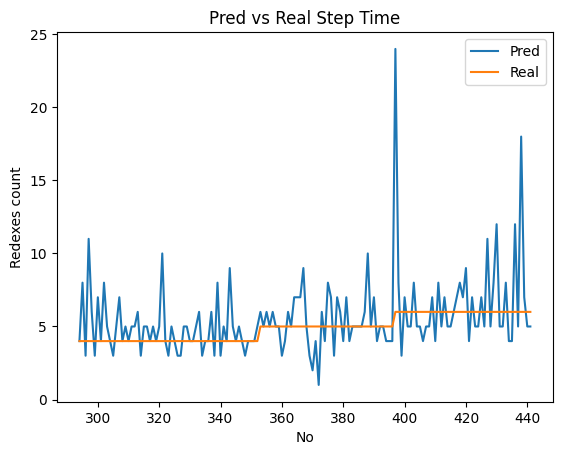

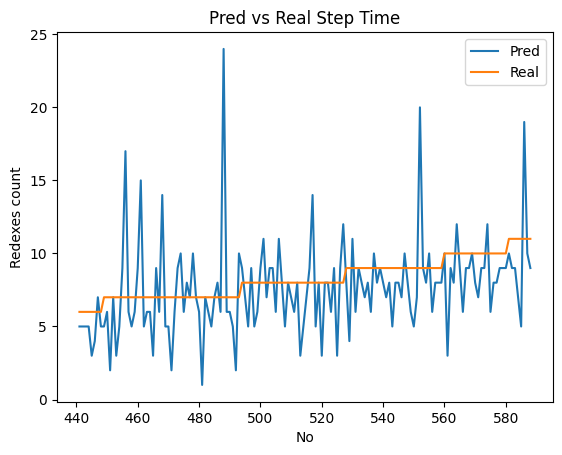

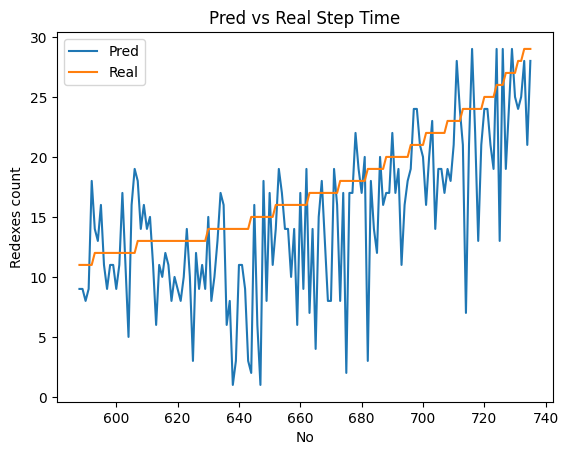

In [14]:
def draw_pred_lines_steps(y_pred, y_real, ranges):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    range_step = int(len(y_pred) / ranges)
    for range_no in range(ranges):
        for key_, val_ in drawing_df.items():
            plt.plot(range(range_no * range_step, ((range_no + 1) * range_step) + 1),
                     val_[range_no * range_step: ((range_no + 1) * range_step) + 1], label=key_)

        plt.xlabel("No")
        plt.ylabel("Redexes count")
        plt.title("Pred vs Real Step Time")
        plt.legend()
        plt.show()


draw_pred_lines_steps(y_test_pred_nums, y_test_nums, 5)

In [22]:
def ite_term():
    x, y, c = Var(), Var(), Var()
    x_, y_, c_ = Atom(x), Atom(y), Atom(c)
    return Lambda(c, Lambda(x, Lambda(y, multi_app_term(c_, x_, y_))))


def true_term():
    x, y = Var(), Var()
    x_ = Atom(x)
    return Lambda(x, Lambda(y, x_))


def num_zero_term():
    s, z = Var(), Var()
    z_ = Atom(z)
    return Lambda(s, Lambda(z, z_))


def num_term(n: int):
    if n <= 0:
        return num_zero_term()
    s, z = Var(), Var()
    s_, z_ = Atom(s), Atom(z)
    core_term = App(s_, z_)
    for _ in range(n - 1):
        core_term = App(s_, core_term)
    return Lambda(s, Lambda(z, core_term))


def multi_app_term(term_0: Term, term_1: Term, *terms: Term):
    res_app_term = App(term_0, term_1)
    for term in terms:
        res_app_term = App(res_app_term, term)
    return res_app_term


def false_term():
    x, y = Var(), Var()
    y_ = Atom(y)
    return Lambda(x, Lambda(y, y_))


def pair_term():
    x, y, p = Var(), Var(), Var()
    x_, y_, p_ = Atom(x), Atom(y), Atom(p)
    return Lambda(x, Lambda(y, Lambda(p, multi_app_term(p_, x_, y_))))


def first_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, true_term()))


def second_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, false_term()))


def succ_term():
    x, y, n = Var(), Var(), Var()
    x_, y_, n_ = Atom(x), Atom(y), Atom(n)
    return Lambda(n, Lambda(x, Lambda(y, App(x_, multi_app_term(n_, x_, y_)))))


def sinc_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(
        p,
        multi_app_term(
            pair_term(),
            App(second_term(), p_),
            App(succ_term(), App(second_term(), p_)),
        ),
    )


def pred_term():
    n, f, x, g, h, u = Var(), Var(), Var(), Var(), Var(), Var()
    n_, f_, x_ = Atom(n), Atom(f), Atom(x)
    g_, h_, u_ = Atom(g), Atom(h), Atom(u)

    return Lambda(n, Lambda(f, Lambda(x, multi_app_term(
        n_,
        Lambda(g, Lambda(h, App(h_, App(g_, f_)))),
        Lambda(u, x_),
        Lambda(u, u_)
    ))))


def plus_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(m, Lambda(n, multi_app_term(n_, succ_term(), m_)))


def subtract_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(n, Lambda(m, multi_app_term(m_, pred_term(), n_)))


def iszero_term():
    x, n = Var(), Var()
    n_ = Atom(n)
    return Lambda(n, App(App(n_, Lambda(x, false_term())), true_term()))


def leq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n, Lambda(m, App(iszero_term(), multi_app_term(subtract_term(), n_, m_)))
    )


def and_term():
    a, b = Var(), Var()
    a_, b_ = Atom(a), Atom(b)
    return Lambda(a, Lambda(b, multi_app_term(ite_term(), a_, b_, a_)))


def eq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n,
        Lambda(
            m,
            multi_app_term(
                and_term(),
                multi_app_term(leq_term(), n_, m_),
                multi_app_term(leq_term(), m_, n_),
            ),
        ),
    )


def i_term():
    x = Var()
    x_ = Atom(x)
    return Lambda(x, x_)


def omega_term(n: int):
    x = Var()
    x_ = Atom(x)
    body_app_term = x_
    for _ in range(n - 1):
        body_app_term = App(body_app_term, x_)
    return Lambda(x, body_app_term)


def multi_i_term(m: int):
    app_term = i_term()
    for _ in range(m - 1):
        app_term = App(app_term, i_term())
    return app_term


def omega_multi_i_term(n: int, m: int):
    return App(omega_term(n), multi_i_term(m))


def term_test_1():
    x, y = Var(), Var()
    x_, y_ = Atom(x), Atom(y)

    return "(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x", \
        App(
            Lambda(x, Lambda(y, y_)),
            App(
                Lambda(x, App(x_, x_)),
                Lambda(x, App(x_, x_))
            )
        )


def term_test_2():
    return "(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(ite_term(), true_term(), num_term(3), num_term(1))


def term_test_3():
    return "(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(ite_term(), false_term(), num_term(0), num_term(4))


def term_test_4():
    return "(PRED 0) == 0 == λx. λy. y", \
        multi_app_term(pred_term(), num_term(0))


def term_test_5():
    return "(PRED 5) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(pred_term(), num_term(5))


def term_test_6():
    return "(PLUS 0 0) == 0 == λx. λy. y", \
        multi_app_term(plus_term(), num_term(0), num_term(0))


def term_test_7():
    return "(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))", \
        multi_app_term(plus_term(), num_term(2), num_term(3))


def term_test_8():
    return "(SUBTRACT 4 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(subtract_term(), num_term(4), num_term(1))


def term_test_9():
    return "(SUBTRACT 3 5) == 0 == λx. λy. y", \
        multi_app_term(subtract_term(), num_term(3), num_term(5))


def term_test_10():
    return "(LEQ 3 2) == FALSE == λx. λy. y", \
        multi_app_term(leq_term(), num_term(3), num_term(2))


def term_test_11():
    return "(LEQ 2 5) == TRUE == λx. λy. x", \
        multi_app_term(leq_term(), num_term(2), num_term(5))


def term_test_12():
    return "(EQ 2 2) == TRUE == λx. λy. x", \
        multi_app_term(eq_term(), num_term(2), num_term(2))


def term_test_13():
    return "(EQ 1 4) == FALSE == λx. λy. y", \
        multi_app_term(eq_term(), num_term(1), num_term(4))


def term_test_14():
    return "Omega(3, 3)  == I == λx. x", \
        omega_multi_i_term(3, 3)


def term_test_15():
    return "GCD_vO 5 2", \
        multi_app_term(gcd_term_v0(), num_term(5), num_term(2))


def term_test_16():
    return "GCD_v1 5 2", \
        multi_app_term(gcd_term_v1(), num_term(5), num_term(2))


def term_test_17():
    return "GCD_v3 5 2", \
        multi_app_term(gcd_term_v3(), num_term(5), num_term(2))


def term_test_18():
    return "PYTHAGOREAN 5 2 2", \
        multi_app_term(
            pythagorean_term(), num_term(5), num_term(2), num_term(2)
        )


def test_function(term_deskr_: str, term_: Term, model_: Sequential):
    prediction_ = model_.predict(tokenize_and_vectorize([term_.simple_str()]), verbose=0)
    count_norm_steps = term_.normalize(LOStrategy())[1]
    cl_pred = np.argmax(prediction_[0][0])
    reg_pred = prediction_[1][0][0] * 30.0
    print(f"{term_deskr_}\nnorm_steps={count_norm_steps}\tcl_pred_steps={cl_pred}\treg_pred_steps={reg_pred}\n")


list_test_functions = (
    term_test_1, term_test_2, term_test_3, term_test_4, term_test_5, term_test_6, term_test_7, term_test_9,
    term_test_10,
    term_test_11, term_test_12, term_test_13, term_test_14, term_test_15, term_test_16, term_test_17, term_test_18)

for term_function in list_test_functions:
    term_deskr, term = term_function()
    test_function(term_deskr, term, model)

(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x
norm_steps=1	cl_pred_steps=2	reg_pred_steps=0.600992739200592

(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))
norm_steps=5	cl_pred_steps=7	reg_pred_steps=5.75883150100708

(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))
norm_steps=5	cl_pred_steps=5	reg_pred_steps=4.5514976978302

(PRED 0) == 0 == λx. λy. y
norm_steps=4	cl_pred_steps=2	reg_pred_steps=3.0530937016010284

(PRED 5) == 4 == λx. λy. (x (x (x (x y))))
norm_steps=15	cl_pred_steps=2	reg_pred_steps=2.976412922143936

(PLUS 0 0) == 0 == λx. λy. y
norm_steps=4	cl_pred_steps=3	reg_pred_steps=2.9028689861297607

(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))
norm_steps=13	cl_pred_steps=6	reg_pred_steps=5.159111022949219

(SUBTRACT 3 5) == 0 == λx. λy. y
norm_steps=39	cl_pred_steps=6	reg_pred_steps=9.302199482917786

(LEQ 3 2) == FALSE == λx. λy. y
norm_steps=28	cl_pred_steps=5	reg_pred_steps=4.130668044090271

(LEQ 2 5) == TRUE == λx. λy. x
norm_steps=37	cl_pred_steps=5	reg_pred_s

In [25]:
list_simplified_omega_terms = []

for n in range(1, 21):
    for m in range(1, 21):
        term_ = omega_multi_i_term(n, m)
        list_simplified_omega_terms.append(term_.simple_str())

list_simplified_omega_terms = tokenize_and_vectorize(list_simplified_omega_terms)

real_redexes_count = []

for n in tqdm(range(1, 21)):
    for m in range(1, 21):
        term_ = omega_multi_i_term(n, m)
        real_redexes_count.append(term_.normalize(LOStrategy())[1])

cl_pred_omega_terms_redexes = []
reg_pred_omega_terms_redexes = []
for rec_ in tqdm(list_simplified_omega_terms):
    prediction_ = model.predict([rec_], verbose=0)
    cl_pred = np.argmax(prediction_[0][0])
    reg_pred = prediction_[1][0][0] * 30.0

    cl_pred_omega_terms_redexes.append(cl_pred)
    reg_pred_omega_terms_redexes.append(reg_pred)

100%|██████████| 400/400 [00:32<00:00, 12.17it/s]


In [26]:
print(cl_pred_omega_terms_redexes)

[1, 2, 3, 4, 5, 6, 6, 6, 7, 7, 9, 9, 9, 10, 10, 11, 11, 11, 11, 13, 2, 4, 5, 6, 7, 7, 9, 9, 9, 10, 10, 11, 12, 13, 13, 13, 13, 13, 13, 16, 2, 5, 5, 6, 7, 7, 9, 9, 9, 10, 10, 11, 11, 13, 13, 13, 13, 13, 13, 13, 2, 5, 5, 6, 7, 7, 9, 9, 9, 10, 11, 11, 11, 13, 13, 13, 13, 13, 16, 17, 3, 5, 6, 7, 7, 9, 9, 9, 10, 11, 12, 11, 13, 13, 13, 13, 16, 17, 17, 17, 3, 5, 6, 7, 9, 9, 10, 11, 13, 13, 13, 13, 13, 13, 16, 17, 17, 17, 17, 17, 4, 5, 6, 7, 9, 9, 11, 13, 13, 13, 13, 13, 13, 13, 16, 17, 17, 17, 17, 17, 4, 5, 7, 7, 9, 15, 13, 12, 13, 13, 13, 13, 13, 13, 16, 17, 17, 17, 17, 17, 4, 5, 7, 9, 9, 15, 13, 13, 13, 13, 13, 13, 13, 16, 17, 17, 17, 17, 17, 17, 4, 5, 7, 9, 9, 21, 13, 13, 13, 13, 13, 13, 13, 16, 17, 17, 17, 17, 17, 17, 4, 5, 7, 9, 9, 21, 13, 13, 13, 13, 13, 13, 17, 17, 17, 17, 17, 17, 17, 17, 4, 5, 7, 9, 9, 21, 12, 12, 13, 13, 13, 13, 17, 17, 17, 17, 17, 17, 17, 17, 4, 5, 7, 9, 20, 21, 12, 13, 13, 13, 13, 17, 17, 17, 17, 17, 17, 17, 17, 17, 4, 7, 9, 9, 21, 21, 12, 13, 13, 13, 13, 17, 17, 

In [27]:
print(reg_pred_omega_terms_redexes)

[-0.06817549467086792, 2.2970299422740936, 3.026968538761139, 3.7772923707962036, 4.692588150501251, 5.7911838591098785, 6.388772875070572, 6.811780035495758, 7.098844796419144, 7.383169233798981, 8.375129699707031, 9.695770740509033, 10.906280279159546, 12.556963562965393, 14.696393609046936, 16.92765176296234, 17.86055088043213, 18.13321352005005, 18.53648543357849, 19.162917137145996, 2.1544061601161957, 3.7361884117126465, 4.657570123672485, 5.904221534729004, 6.640316694974899, 7.118763774633408, 8.61519455909729, 9.903447031974792, 11.35585606098175, 13.262511491775513, 15.530701875686646, 18.990654945373535, 20.52350878715515, 20.497148036956787, 20.43419122695923, 19.583424925804138, 17.672937512397766, 17.152463793754578, 17.04050302505493, 16.825886964797974, 2.0384524762630463, 3.8807769119739532, 4.783952683210373, 5.897442698478699, 6.466129124164581, 6.8414609134197235, 8.086853921413422, 9.345375001430511, 10.928565859794617, 12.9346364736557, 15.071686506271362, 17.3287

In [28]:
print(real_redexes_count)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105, 112, 119, 126, 133, 140, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135, 144, 153, 162, 171, 180, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 11, 22, 33, 44, 55, 66, 77, 88, 99, 110, 121, 132, 143, 154, 165, 176, 187, 198, 209, 220, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, 240, 

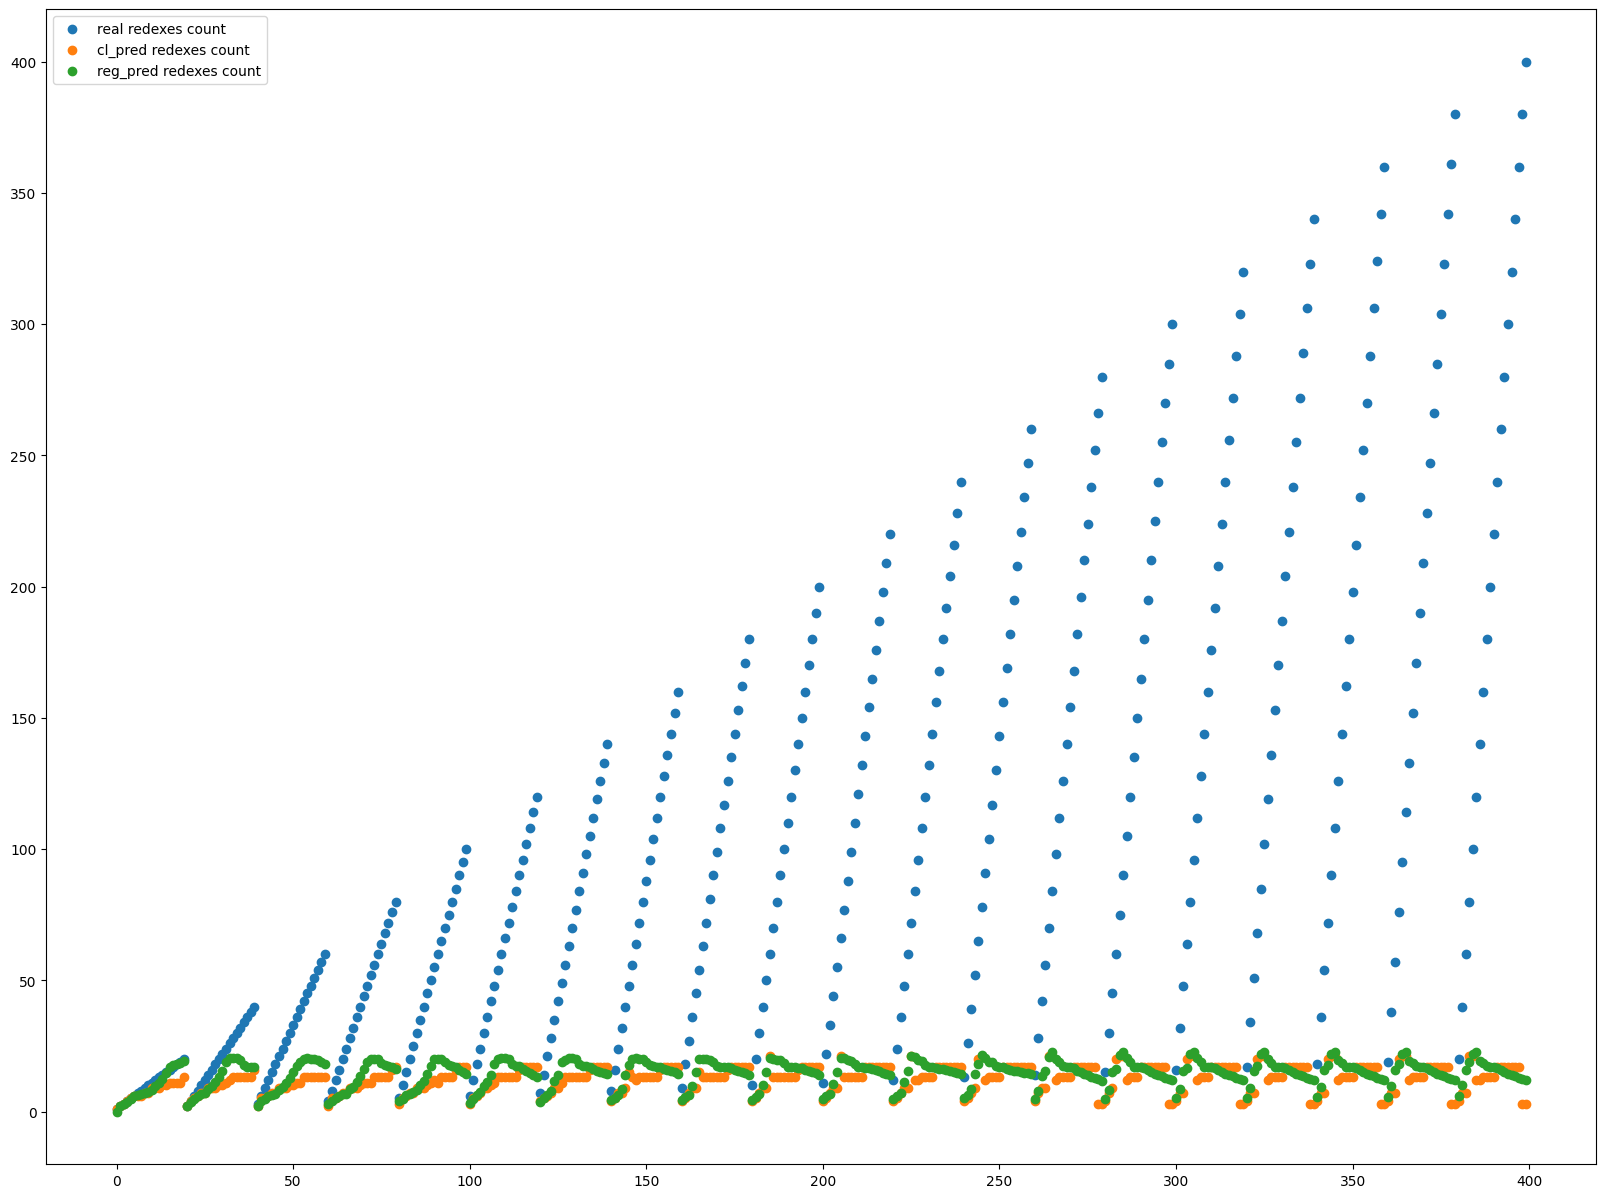

In [32]:
rcParams['figure.figsize'] = 20, 15

plt.scatter(range(0, len(real_redexes_count)), real_redexes_count, label="real redexes count")
plt.scatter(range(0, len(real_redexes_count)), cl_pred_omega_terms_redexes, label="cl_pred redexes count")
plt.scatter(range(0, len(real_redexes_count)), reg_pred_omega_terms_redexes, label="reg_pred redexes count")

plt.legend()
plt.show()

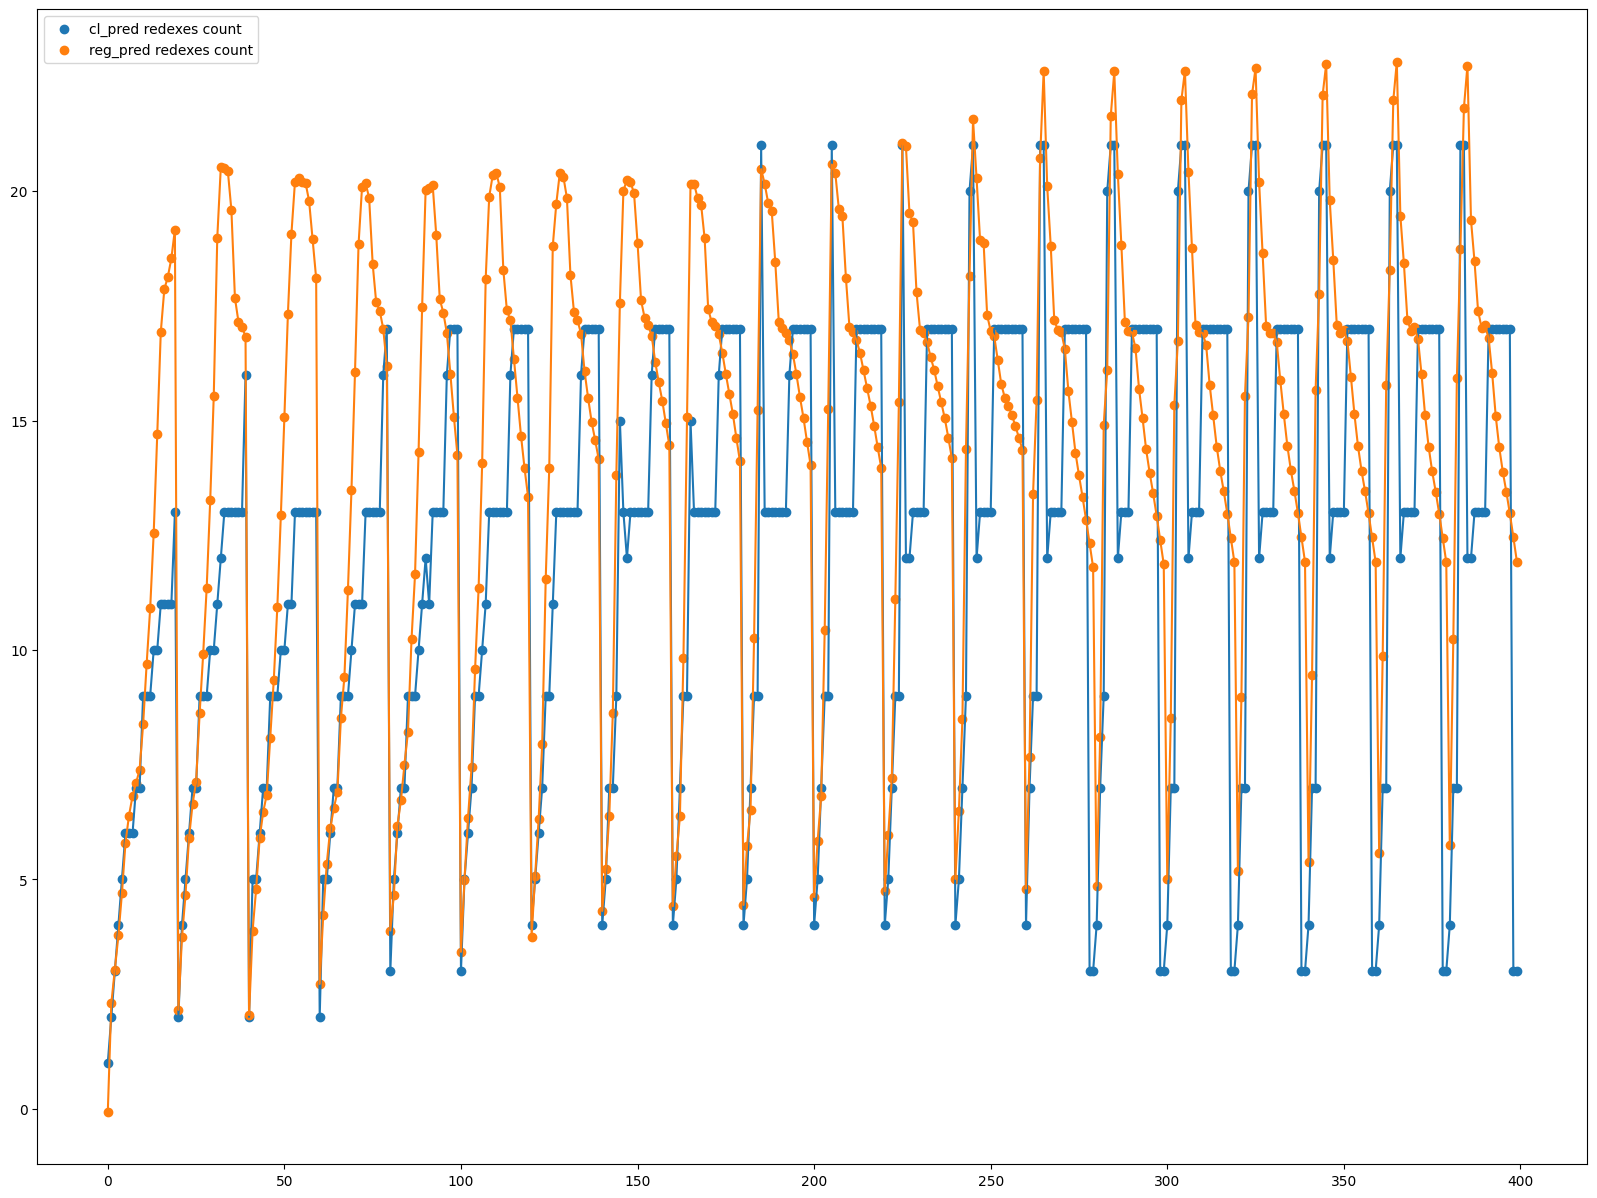

In [34]:
rcParams['figure.figsize'] = 20, 15

plt.scatter(range(0, len(real_redexes_count)), cl_pred_omega_terms_redexes, label="cl_pred redexes count")
plt.plot(range(0, len(real_redexes_count)), cl_pred_omega_terms_redexes)
plt.scatter(range(0, len(real_redexes_count)), reg_pred_omega_terms_redexes, label="reg_pred redexes count")
plt.plot(range(0, len(real_redexes_count)), reg_pred_omega_terms_redexes)

plt.legend()
plt.show()

In [35]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


print("Test accuracy:", calculate_accuracy(real_redexes_count, cl_pred_omega_terms_redexes))

Test accuracy: 0.02


In [36]:
green_dots = []
red_dots = []

for n in range(0, 20):
    for m in range(0, 20):
        val = cl_pred_omega_terms_redexes[n * 20 + m]
        val_real = real_redexes_count[n * 20 + m]

        if val == val_real:
            green_dots.append((n + 1, m + 1))
        else:
            red_dots.append((n + 1, m + 1))


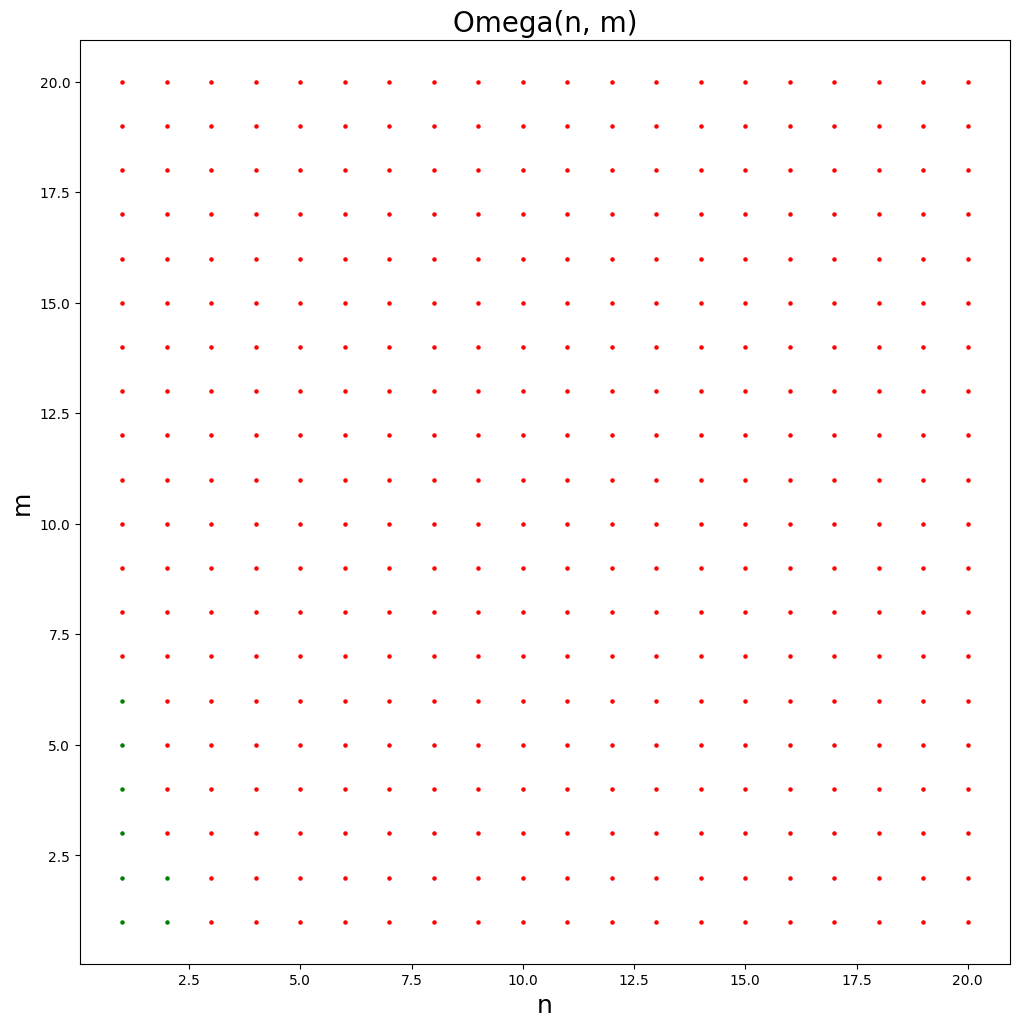

In [37]:
plt.figure(figsize=(12, 12))

green_dots = np.array(green_dots)
red_dots = np.array(red_dots)

plt.scatter(green_dots[:, 0], green_dots[:, 1], s=5, c='green', )
plt.scatter(red_dots[:, 0], red_dots[:, 1], s=5, c='red', )

plt.xlabel("n", fontsize=18)
plt.ylabel("m", fontsize=18)
plt.title("Omega(n, m)", fontsize=20)
plt.show()

# Do additional metrics testing

In [51]:
y_train_cl_pred_nums = [np.argmax(y_) for y_ in y_train_pred]
y_train_reg_pred_nums = np.array([y_[0][0] for y_ in y_train_pred_reg]) * 30.0

y_train_nums = encoder.inverse_transform(y_train)

In [53]:
y_test_cl_pred_nums = [np.argmax(y_) for y_ in y_test_pred]
y_test_reg_pred_nums = np.array([y_[0][0] for y_ in y_test_pred_reg]) * 30.0

y_test_nums = encoder.inverse_transform(y_test)

## Mean Squared Error

In [55]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

In [56]:
mse_train = mean_squared_error(y_train_nums, y_train_cl_pred_nums)
mse_train_reg = mean_squared_error(y_train_nums, y_train_reg_pred_nums)
print("Train {Mean Squared Error}:", mse_train)
print("Train reg {Mean Squared Error}:", mse_train_reg)

mse_test = mean_squared_error(y_test_nums, y_test_cl_pred_nums)
mse_test_reg = mean_squared_error(y_test_nums, y_test_reg_pred_nums)
print("Test {Mean Squared Error}:", mse_test)
print("Test reg {Mean Squared Error}:", mse_test_reg)

Train {Mean Squared Error}: 3.0616531165311653
Train reg {Mean Squared Error}: 4.827956727298874
Test {Mean Squared Error}: 11.073071718538566
Test reg {Mean Squared Error}: 10.215875560685607


## Mean Absolute Error

In [59]:
mae_train = mean_absolute_error(y_train_nums, y_train_cl_pred_nums)
mae_train_reg = mean_absolute_error(y_train_nums, y_train_reg_pred_nums)
print("Train {Mean Absolute Error}:", mae_train)
print("Train reg {Mean Absolute Error}:", mae_train_reg)

mae_test = mean_absolute_error(y_test_nums, y_test_cl_pred_nums)
mae_test_reg = mean_absolute_error(y_test_nums, y_test_reg_pred_nums)
print("Test {Mean Absolute Error}:", mae_test)
print("Test reg{Mean Absolute Error}:", mae_test_reg)

Train {Mean Absolute Error}: 0.7134146341463414
Train reg {Mean Absolute Error}: 1.4506636488587068
Test {Mean Absolute Error}: 1.8741542625169147
Test reg{Mean Absolute Error}: 2.100439532845204


## Mean Absolute Percentage Error

In [61]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    percentage_errors = np.abs((y_true - y_pred) / y_true_fix) * 100
    mape = np.mean(percentage_errors)
    return mape


mape_train = mean_absolute_percentage_error(y_train_nums, y_train_cl_pred_nums)
mape_train_reg = mean_absolute_percentage_error(y_train_nums, y_train_reg_pred_nums)
print("Train {Mean Absolute Percentage Error}:", mape_train)
print("Train reg {Mean Absolute Percentage Error}:", mape_train_reg)

mape_test = mean_absolute_percentage_error(y_test_nums, y_test_cl_pred_nums)
mape_test_reg = mean_absolute_percentage_error(y_test_nums, y_test_reg_pred_nums)
print("Test {Mean Absolute Percentage Error}:", mape_test)
print("Test reg {Mean Absolute Percentage Error}:", mape_test_reg)

Train {Mean Absolute Percentage Error}: 8.64712889496195
Train reg {Mean Absolute Percentage Error}: 68471.69610549035
Test {Mean Absolute Percentage Error}: 1384.7677052991537
Test reg {Mean Absolute Percentage Error}: 74687.5200296059


## Percentage of Explained Variance (PEV)

In [62]:
# Calculate Variance of the target variable
variance_y_test = np.var(y_test_nums)
variance_y_train = np.var(y_train_nums)

# Calculate Percentage of Explained Variance (PEV)
pev_test = (1 - mse_test / variance_y_test) * 100
pev_test_reg = (1 - mse_test_reg / variance_y_test) * 100
pev_train = (1 - mse_train / variance_y_train) * 100
pev_train_reg = (1 - mse_train_reg / variance_y_train) * 100

print("Train {Percentage of Explained Variance}:", pev_train)
print("Train reg {Percentage of Explained Variance}:", pev_train_reg)
print("Test {Percentage of Explained Variance}:", pev_test)
print("Test reg {Percentage of Explained Variance}:", pev_test_reg)

Train {Percentage of Explained Variance}: 92.65057271893676
Train reg {Percentage of Explained Variance}: 88.41060187654281
Test {Percentage of Explained Variance}: 74.01434565040313
Test reg {Percentage of Explained Variance}: 76.02596479583654


## Mean Bias Deviation

In [63]:
def mean_bias_deviation(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    n = len(y_true)
    mbd = np.sum((y_pred - y_true) / y_true_fix) * 100 / n
    return mbd


mbd_train = mean_bias_deviation(y_train_nums, y_train_cl_pred_nums)
mbd_train_reg = mean_bias_deviation(y_train_nums, y_train_reg_pred_nums)
print("Train {Mean Bias Deviation}:", mbd_train)
print("Train reg {Mean Bias Deviation}:", mbd_train_reg)

mdb_test = mean_bias_deviation(y_test_nums, y_test_cl_pred_nums)
mdb_test_reg = mean_bias_deviation(y_test_nums, y_test_reg_pred_nums)
print("Test {Mean Bias Deviation}:", mdb_test)
print("Test reg {Mean Bias Deviation}:", mdb_test_reg)

Train {Mean Bias Deviation}: -0.052965791700021594
Train reg {Mean Bias Deviation}: 66363.97082120382
Test {Mean Bias Deviation}: 1363.2024697635886
Test reg {Mean Bias Deviation}: 72957.04842389177


## Coefficient of Correlation (Pearson's r)

In [64]:
coc_test = np.corrcoef(y_test_cl_pred_nums, y_test_nums)[0, 1]
coc_test_reg = np.corrcoef(y_test_reg_pred_nums, y_test_nums)[0, 1]
coc_train = np.corrcoef(y_train_cl_pred_nums, y_train_nums)[0, 1]
coc_train_reg = np.corrcoef(y_train_reg_pred_nums, y_train_nums)[0, 1]

print("Train {Mean Bias Deviation}:", coc_train)
print("Train reg {Mean Bias Deviation}:", coc_train_reg)
print("Test {Mean Bias Deviation}:", coc_test)
print("Test reg {Mean Bias Deviation}:", coc_test_reg)

Train {Mean Bias Deviation}: 0.9637820376194665
Train reg {Mean Bias Deviation}: 0.947665986325299
Test {Mean Bias Deviation}: 0.8650733977432106
Test reg {Mean Bias Deviation}: 0.8768480190421475
